# Conditional VAE

Train a conditional VAE on the M-NIST data set, and visualize the data we can generate by choosing values for the latent space and decoding them. 



## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Parameters
latent_dim = 20
batch_size = 128
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Convolutional encoder and decoders

We condition the encoder and decoder on the ground truth digit (using a one-hot
encoded vector).  This means that we have one channel for the image data, and then
all zeros or all ones (one hot) for each of the digit values.  So ten channels!

In [2]:
# Encoder
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(1 + 10, 32, 4, 2, 1), # input channels: image + label channels
      nn.ReLU(),
      nn.Conv2d(32, 64, 4, 2, 1),
      nn.ReLU(),
      nn.Flatten()
    )
    self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
    self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

  def forward(self, x, y):
    # Expand labels to same spatial size
    y = y.view(y.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
    x = torch.cat([x, y], dim=1)
    x = self.conv(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

# Decoder
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(latent_dim + 10, 64 * 7 * 7)
    self.deconv = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 4, 2, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 1, 4, 2, 1),
      nn.Sigmoid()
    )

  def forward(self, z, y):
    z = torch.cat([z, y], dim=1)
    x = self.fc(z)
    x = x.view(-1, 64, 7, 7)
    x = self.deconv(x)
    return x


In [3]:
# CVAE Model
class CVAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std
    
  def forward(self, x, y):
    mu, logvar = self.encoder(x, y)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decoder(z, y)
    return x_hat, mu, logvar


## Loss

The loss does not reference y: it is used as input to the encoder and decoder, and is know for each image (e.g. supervized learning)


In [4]:
def loss_fn(x_hat, x, mu, logvar):
  recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_loss


In [5]:
# Initialize
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(epochs):
  model.train()
  train_loss = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    y_onehot = torch.nn.functional.one_hot(y, num_classes=10).float()

    x_hat, mu, logvar = model(x, y_onehot)
    loss = loss_fn(x_hat, x, mu, logvar)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 155.4867
Epoch 2, Loss: 110.5416
Epoch 3, Loss: 105.5676
Epoch 4, Loss: 103.2356
Epoch 5, Loss: 101.8124
Epoch 6, Loss: 100.8166
Epoch 7, Loss: 100.0632
Epoch 8, Loss: 99.5137
Epoch 9, Loss: 98.9666
Epoch 10, Loss: 98.5351


# Generate a bunch of the same digit

This model struggles with 2s, so I chose that digit for the images

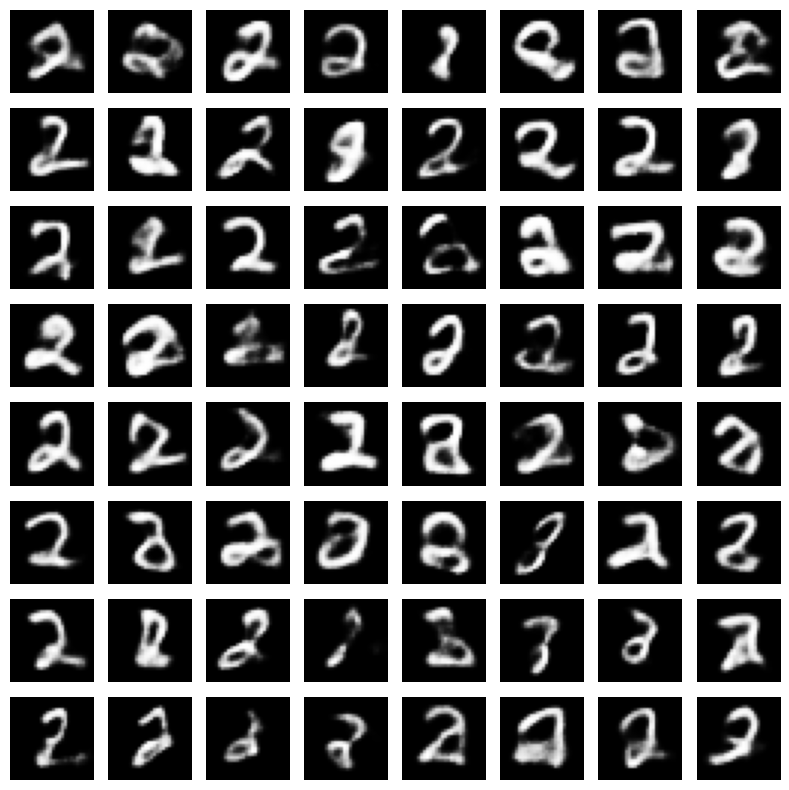

In [27]:
# Generate samples of a specific digit
digit_to_generate = 2  # Choose any digit 0-9
num_samples = 64

model.eval()
with torch.no_grad():
  z = torch.randn(num_samples, latent_dim).to(device)
  y = torch.full((num_samples,), digit_to_generate, dtype=torch.long).to(device)
  y_onehot = torch.nn.functional.one_hot(y, num_classes=10).float()

  samples = model.decoder(z, y_onehot)

# Plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(samples[i][0].cpu(), cmap='gray')
  ax.axis('off')

plt.tight_layout()
plt.show()


# Interpolation

Just for fun

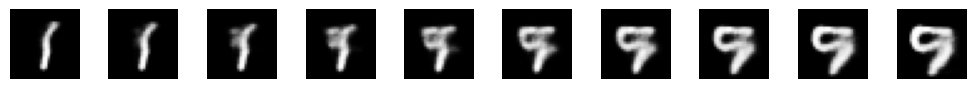

In [8]:
# Interpolate between two digits
digit_start = 1
digit_end = 9
num_steps = 10  # number of interpolation steps

model.eval()
with torch.no_grad():
  # Sample random z for start and end
  z_start = torch.randn(1, latent_dim).to(device)
  z_end = torch.randn(1, latent_dim).to(device)

  # Labels
  y_start = torch.full((1,), digit_start, dtype=torch.long).to(device)
  y_end = torch.full((1,), digit_end, dtype=torch.long).to(device)
  y_start_onehot = torch.nn.functional.one_hot(y_start, num_classes=10).float()
  y_end_onehot = torch.nn.functional.one_hot(y_end, num_classes=10).float()

  # Interpolate z
  interpolated_z = []
  interpolated_y = []

  for alpha in torch.linspace(0, 1, steps=num_steps):
    z = (1 - alpha) * z_start + alpha * z_end
    y = (1 - alpha) * y_start_onehot + alpha * y_end_onehot
    interpolated_z.append(z)
    interpolated_y.append(y)

  interpolated_z = torch.cat(interpolated_z, dim=0)
  interpolated_y = torch.cat(interpolated_y, dim=0)

  # Decode
  samples = model.decoder(interpolated_z, interpolated_y)

# Plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 1))
for i, ax in enumerate(axes.flat):
  ax.imshow(samples[i][0].cpu(), cmap='gray')
  ax.axis('off')

plt.tight_layout()
plt.show()


# Same sample, different digits

For a bunch of gaussian samples, condition the decoder on each digit so we can see how the specific sample affects different digits.  The sample is sort of like the "font"

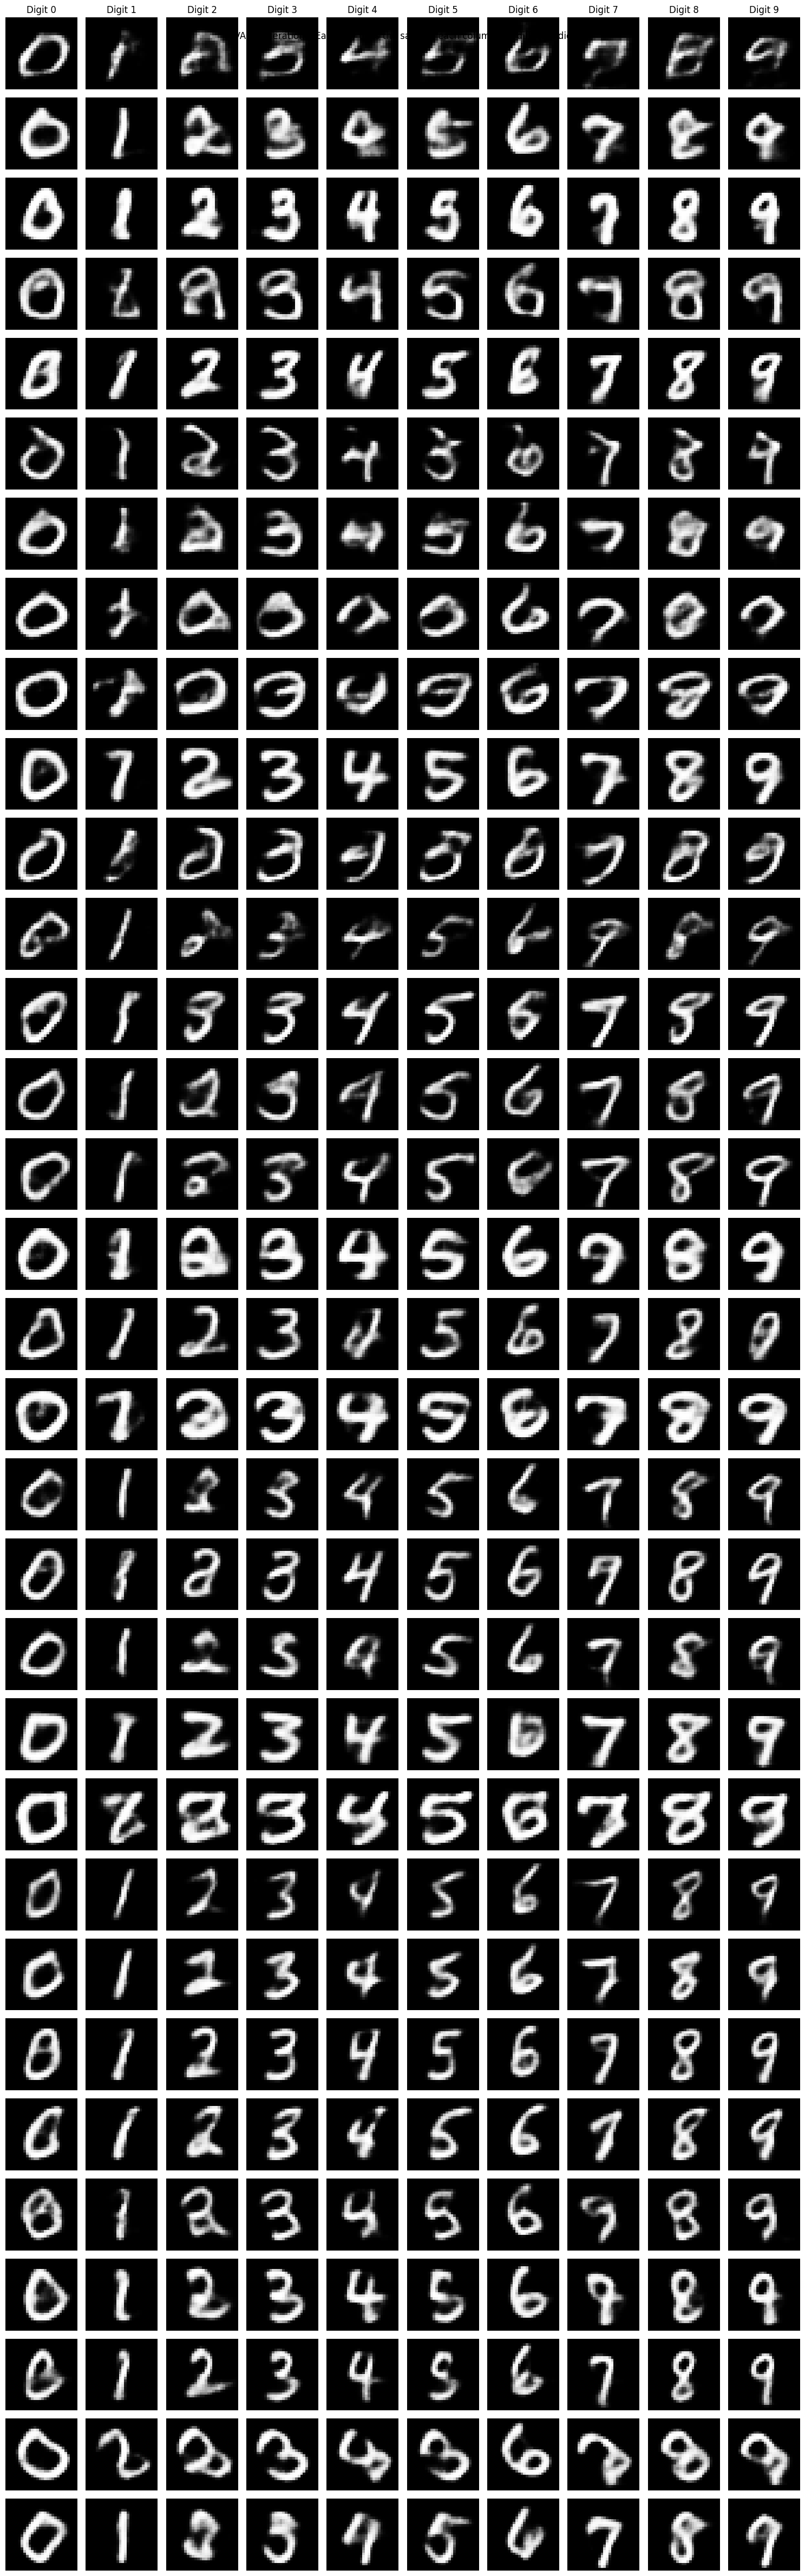

In [ ]:
num_digits = 10
samples_per_digit = 32  


model.eval()
with torch.no_grad():
  # Sample random z for start and end

  z_s = torch.randn(samples_per_digit, latent_dim).to(device)

  # Create digit labels (0-9)
  digits = torch.arange(num_digits).to(device)
  
  # Create one-hot encoded labels for all digits
  y_s = torch.nn.functional.one_hot(digits, num_classes=10).float()  # shape: [10, 10]

  z_expanded = z_s.unsqueeze(1).expand(-1, num_digits, -1)
  y_expanded = y_s.unsqueeze(0).expand(samples_per_digit, -1, -1)

  z_flat = z_expanded.reshape(-1, latent_dim)  # shape: [80, latent_dim]
  y_flat = y_expanded.reshape(-1, 10)  # shape: [80, 10]
  
  # Generate all samples at once
  samples = model.decoder(z_flat, y_flat)  # shape: [80, 1, 28, 28]


fig, axes = plt.subplots(samples_per_digit, num_digits, figsize=(15, 48))
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        img_idx = i * num_digits + j
        ax.imshow(samples[img_idx][0].cpu(), cmap='gray')
        ax.axis('off')
        if i == 0:  # Add column labels (digits) on top
            ax.set_title(f'Digit {j}')
    if j == 0:  # Add row labels (z index) on left
        ax_row[0].set_ylabel(f'z_{i}', rotation=0, labelpad=20)

plt.suptitle('CVAE Generations: Each row uses the same z, each column is a different digit')
plt.tight_layout()
plt.show()


# Show the mean value

What does the all zeros in latent space look like for each digit?

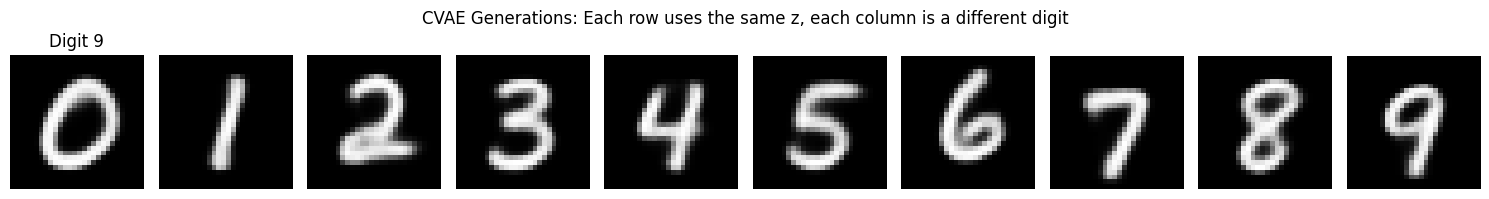

In [23]:

num_digits = 10


model.eval()
with torch.no_grad():
  # Sample random z for start and end

  z_s = torch.zeros(1, latent_dim).to(device)

  # Create digit labels (0-9)
  digits = torch.arange(num_digits).to(device)
  
  # Create one-hot encoded labels for all digits
  y_s = torch.nn.functional.one_hot(digits, num_classes=10).float()  # shape: [10, 10]

  z_expanded = z_s.unsqueeze(1).expand(-1, num_digits, -1)
  y_expanded = y_s.unsqueeze(0).expand(1, -1, -1)

  z_flat = z_expanded.reshape(-1, latent_dim)  # shape: [80, latent_dim]
  y_flat = y_expanded.reshape(-1, 10)  # shape: [80, 10]
  
  # Generate all samples at once
  samples = model.decoder(z_flat, y_flat)  # shape: [80, 1, 28, 28]


fig, axes = plt.subplots(1, num_digits, figsize=(15, 2))
for i, ax in enumerate(axes):
  img_idx = i
  ax.imshow(samples[img_idx][0].cpu(), cmap='gray')
  ax.axis('off')
  if i == 0:  # Add column labels (digits) on top
      ax.set_title(f'Digit {j}')

plt.suptitle('CVAE Generations: Each row uses the same z, each column is a different digit')
plt.tight_layout()
plt.show()


# Sweep each feature independently

For each dimension in latent space, sweep from low to high values, holding all of the
other dimensions at zero so that we can get a visual intuition for the "function" of each dimensions

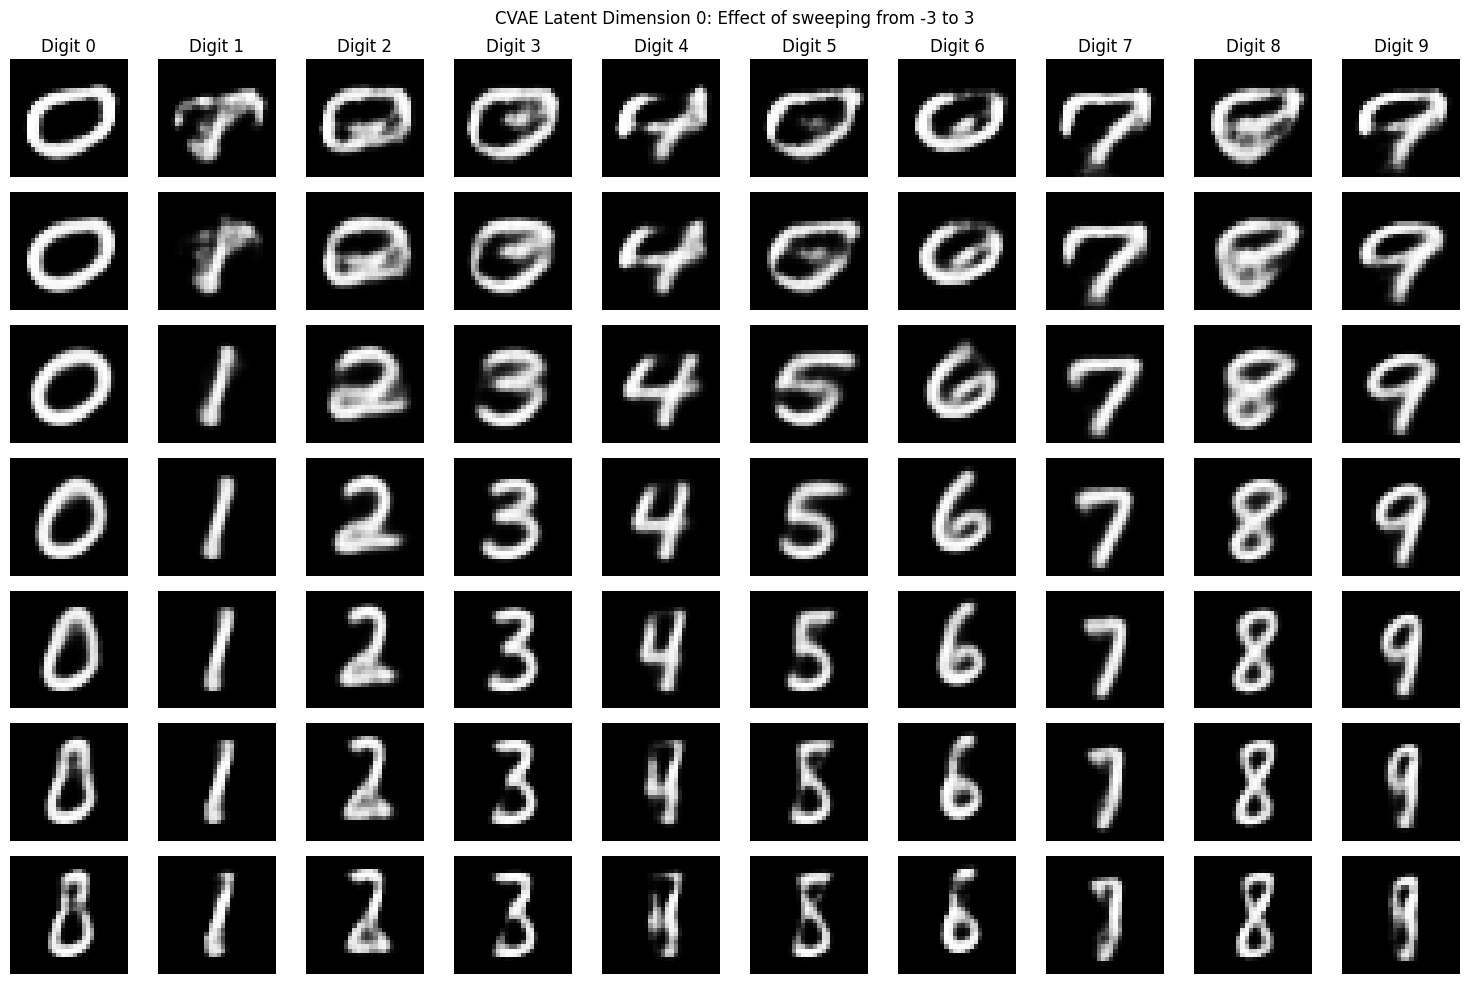

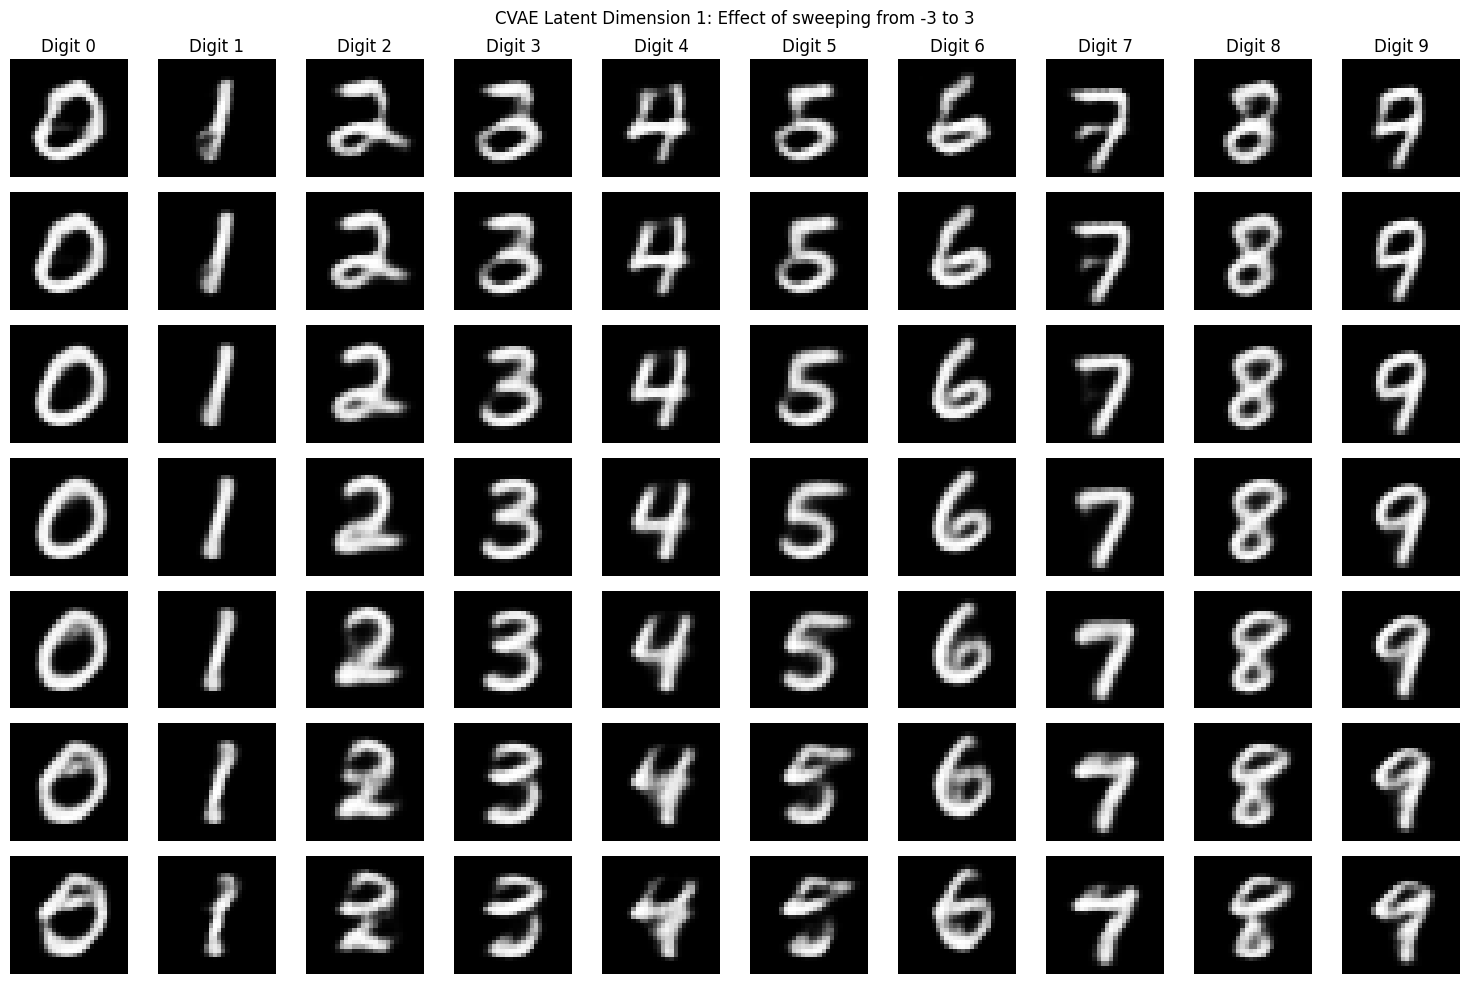

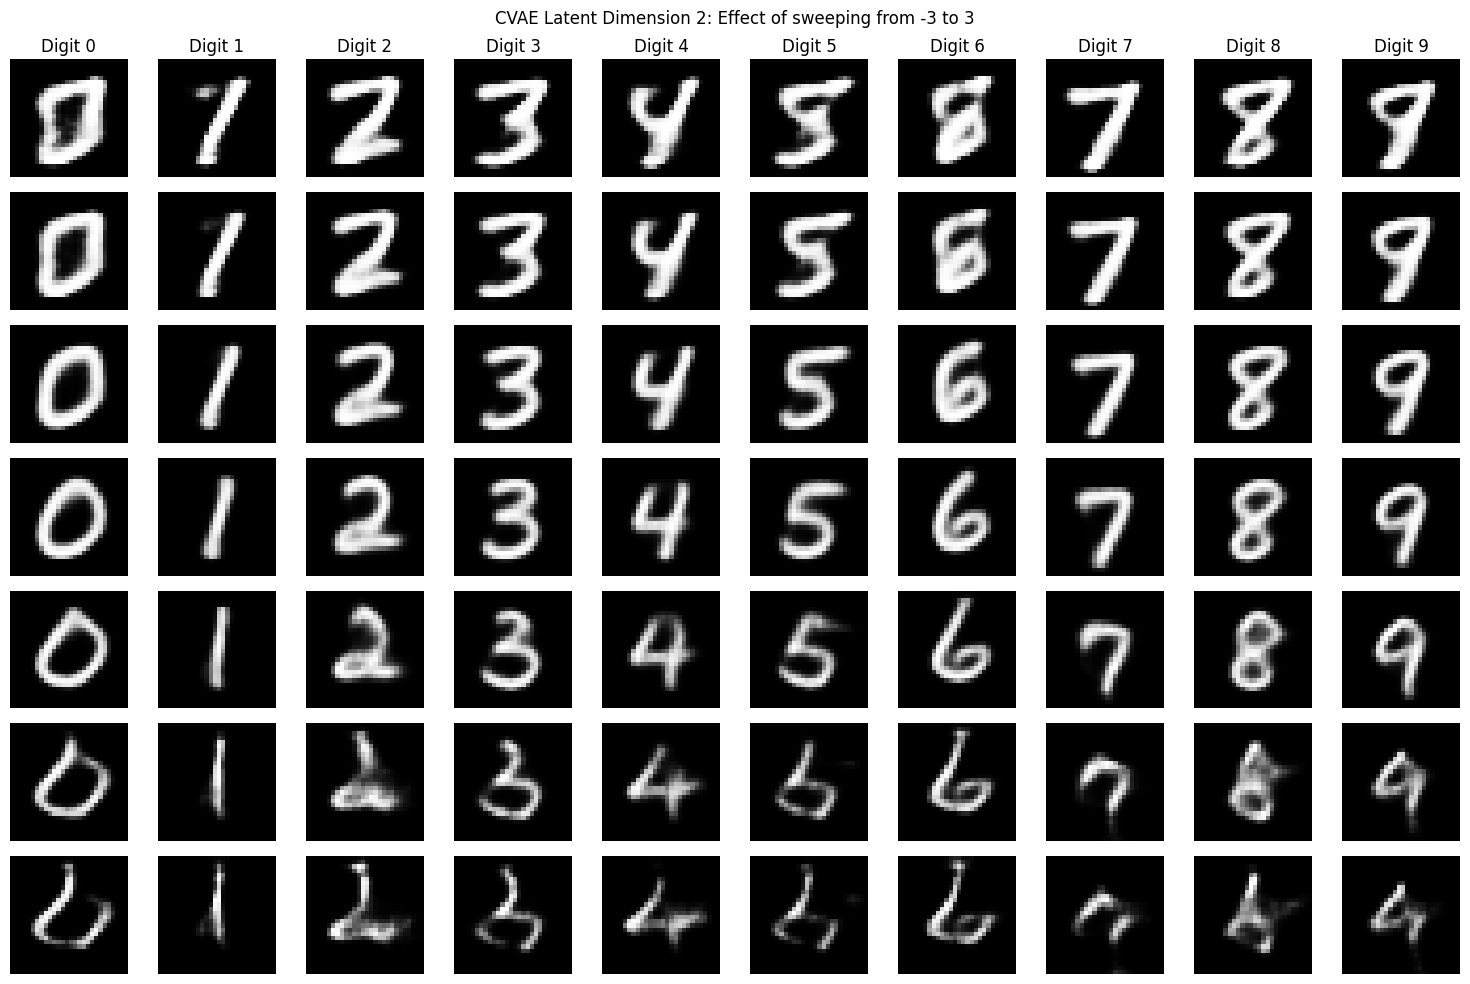

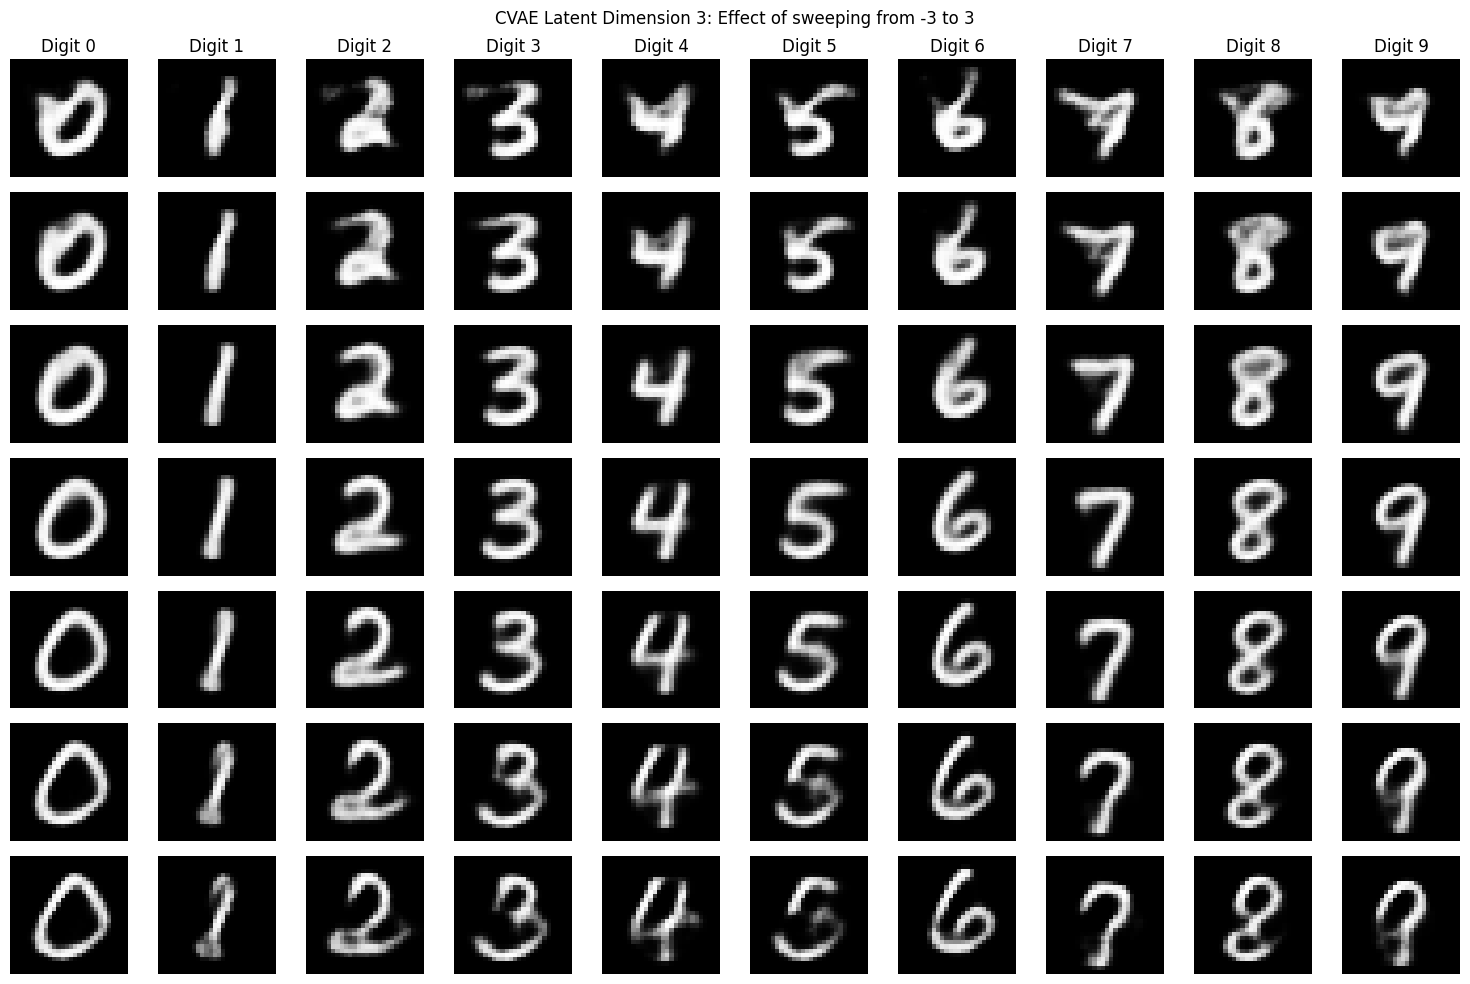

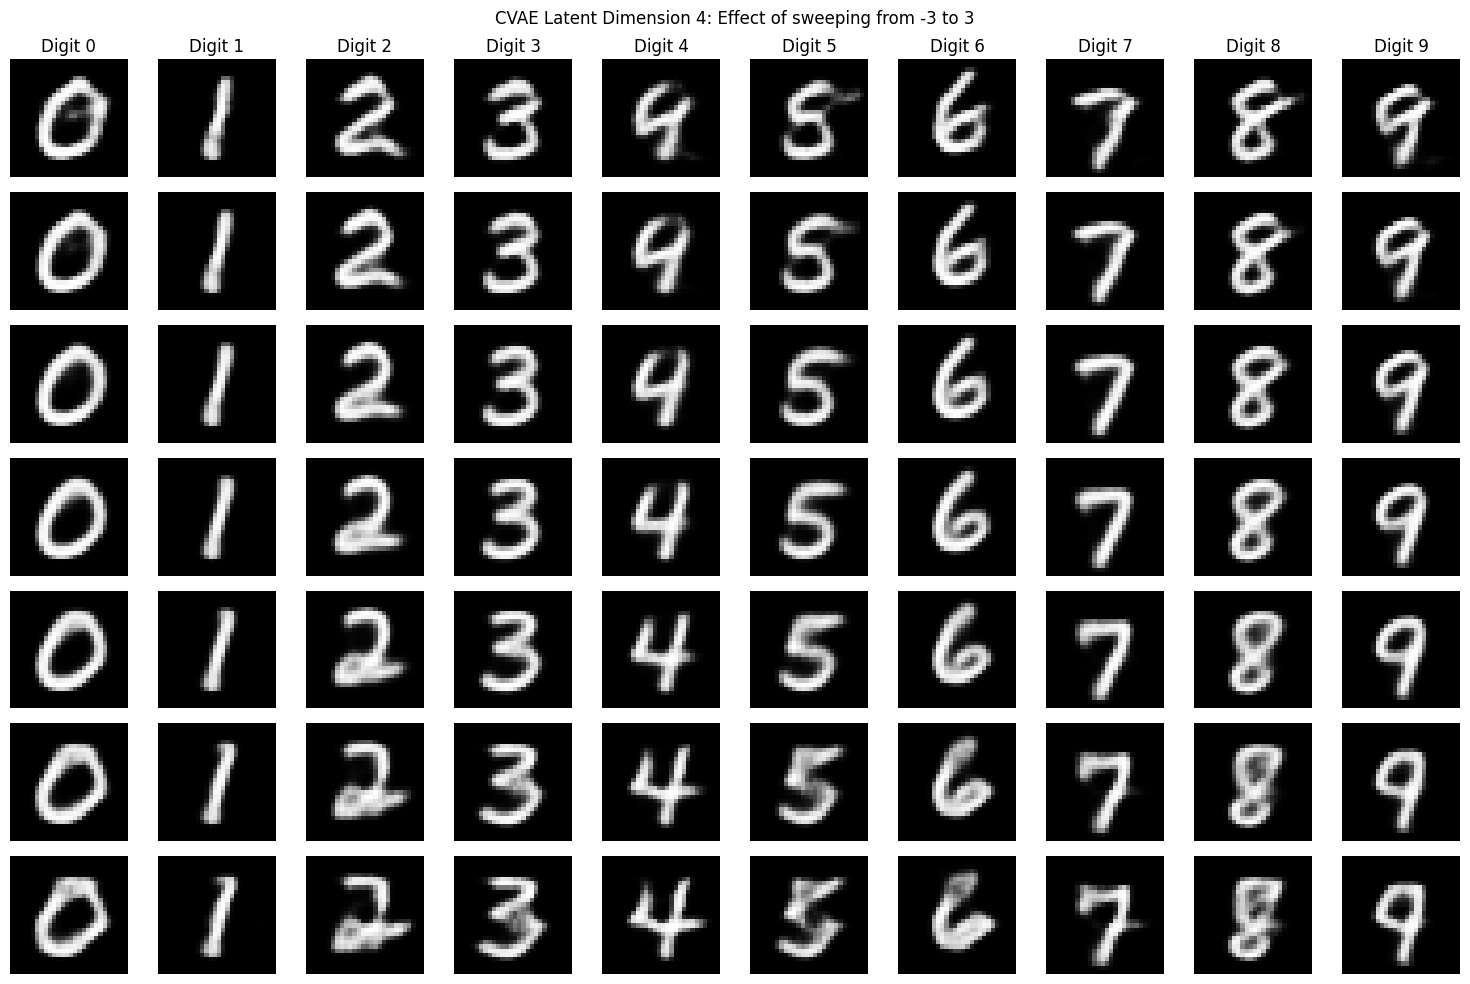

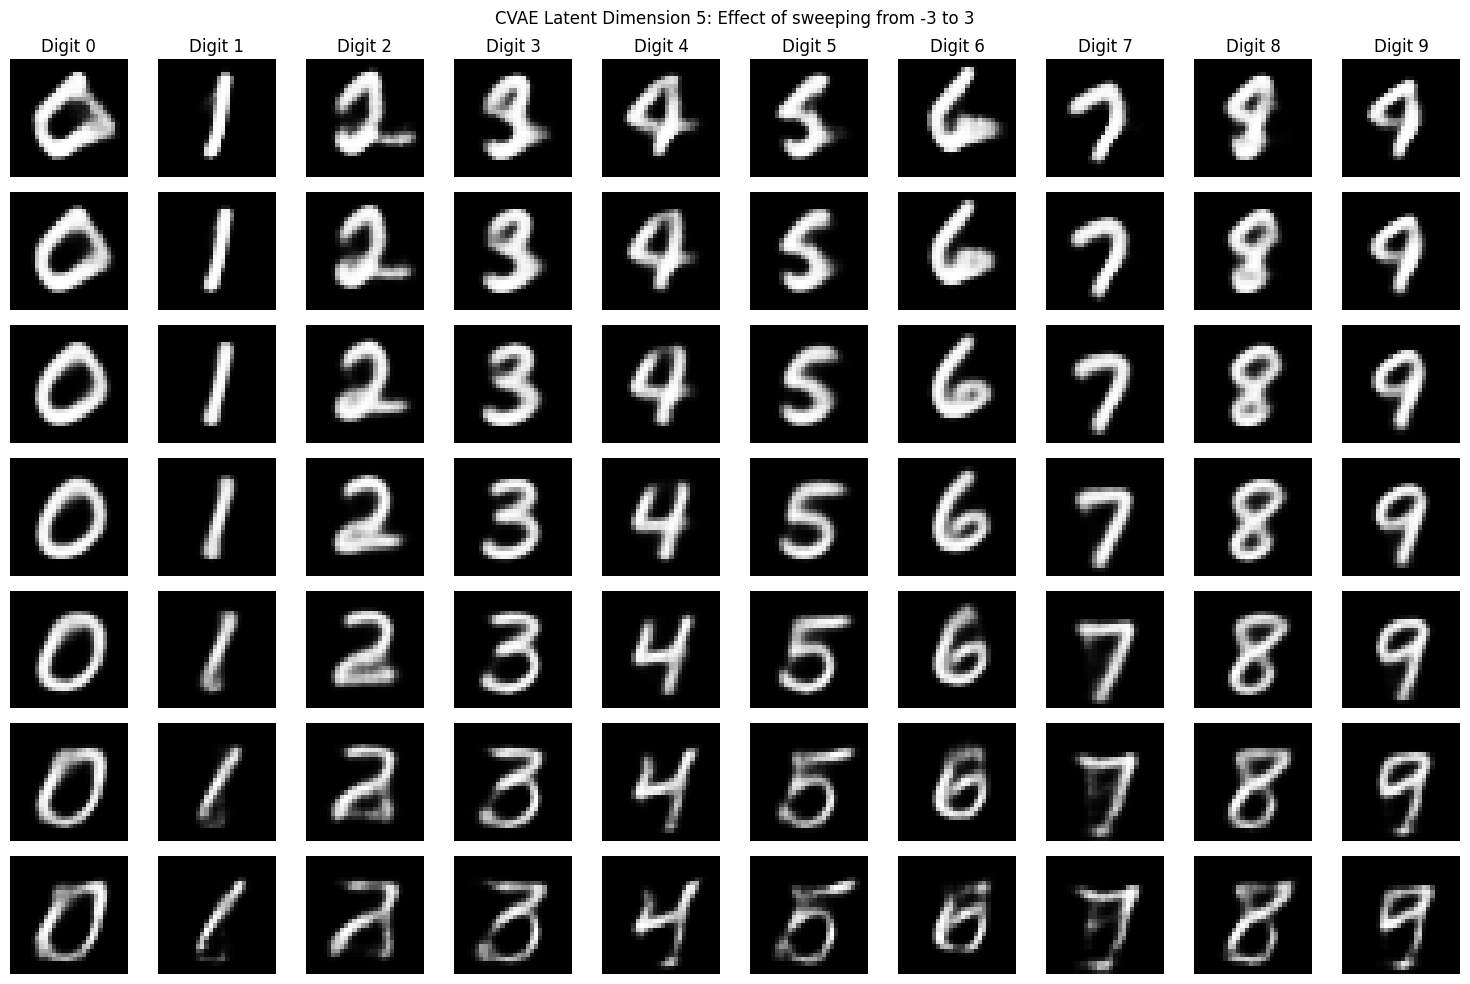

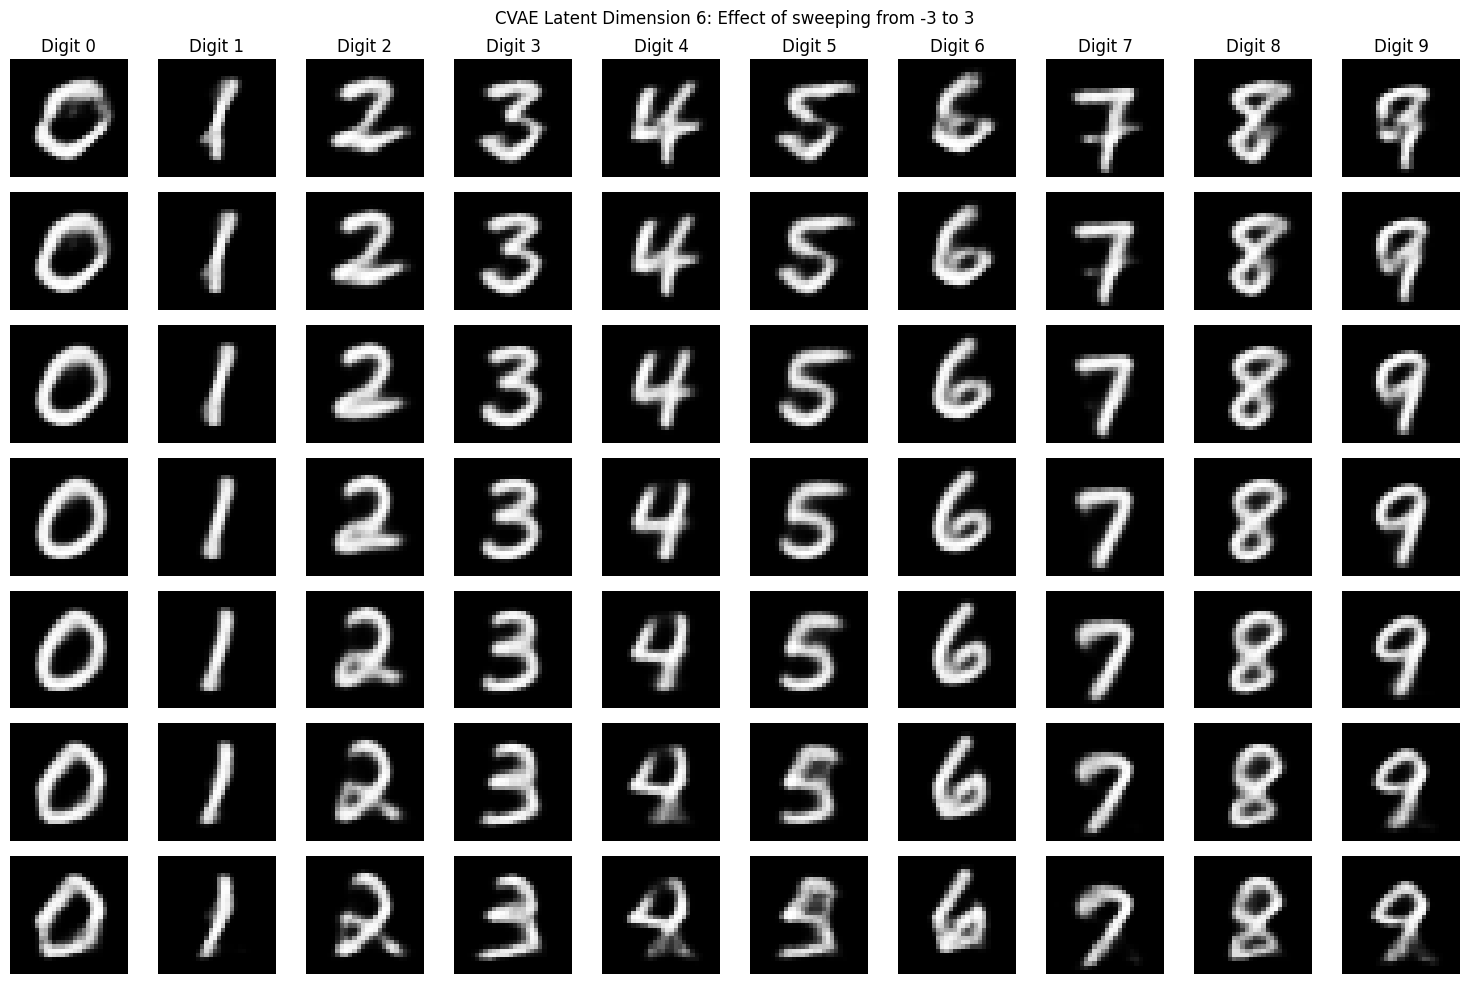

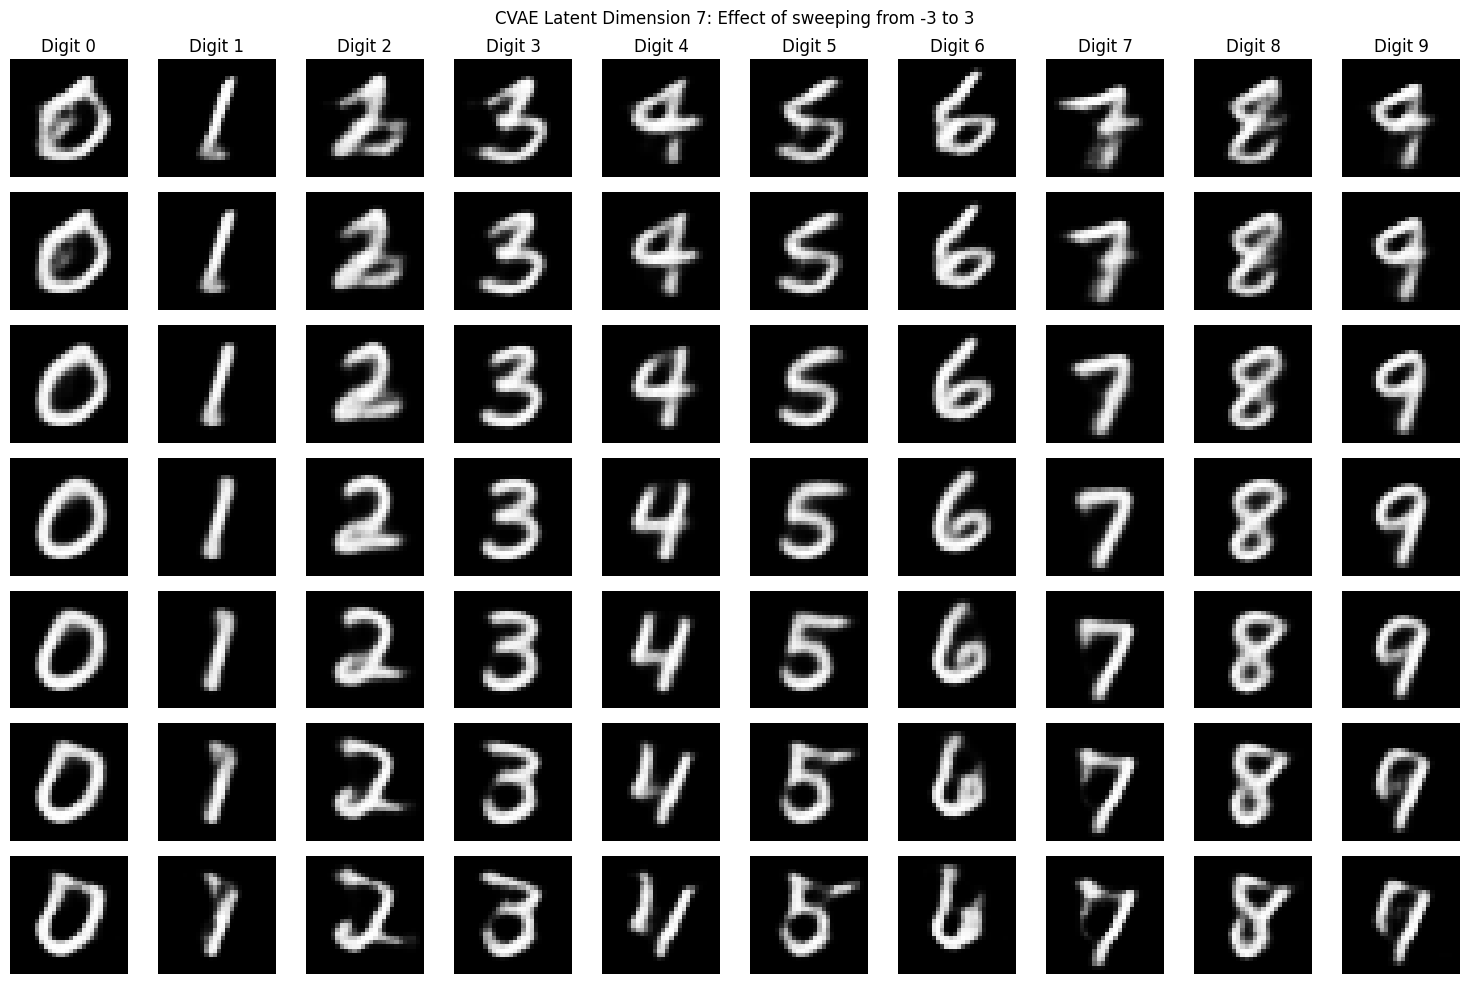

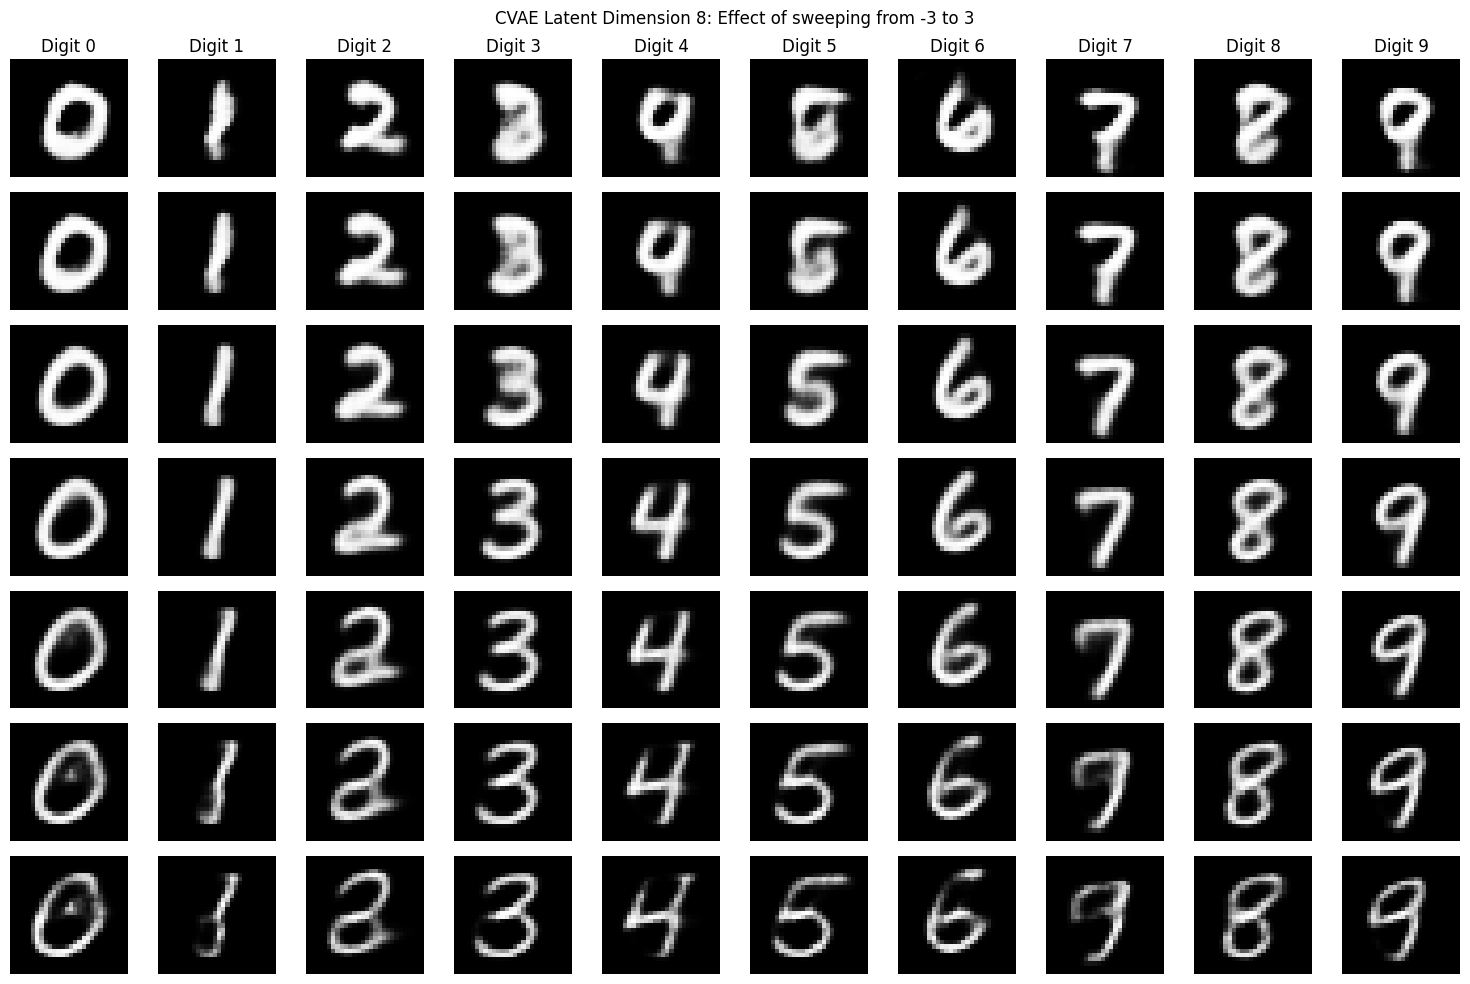

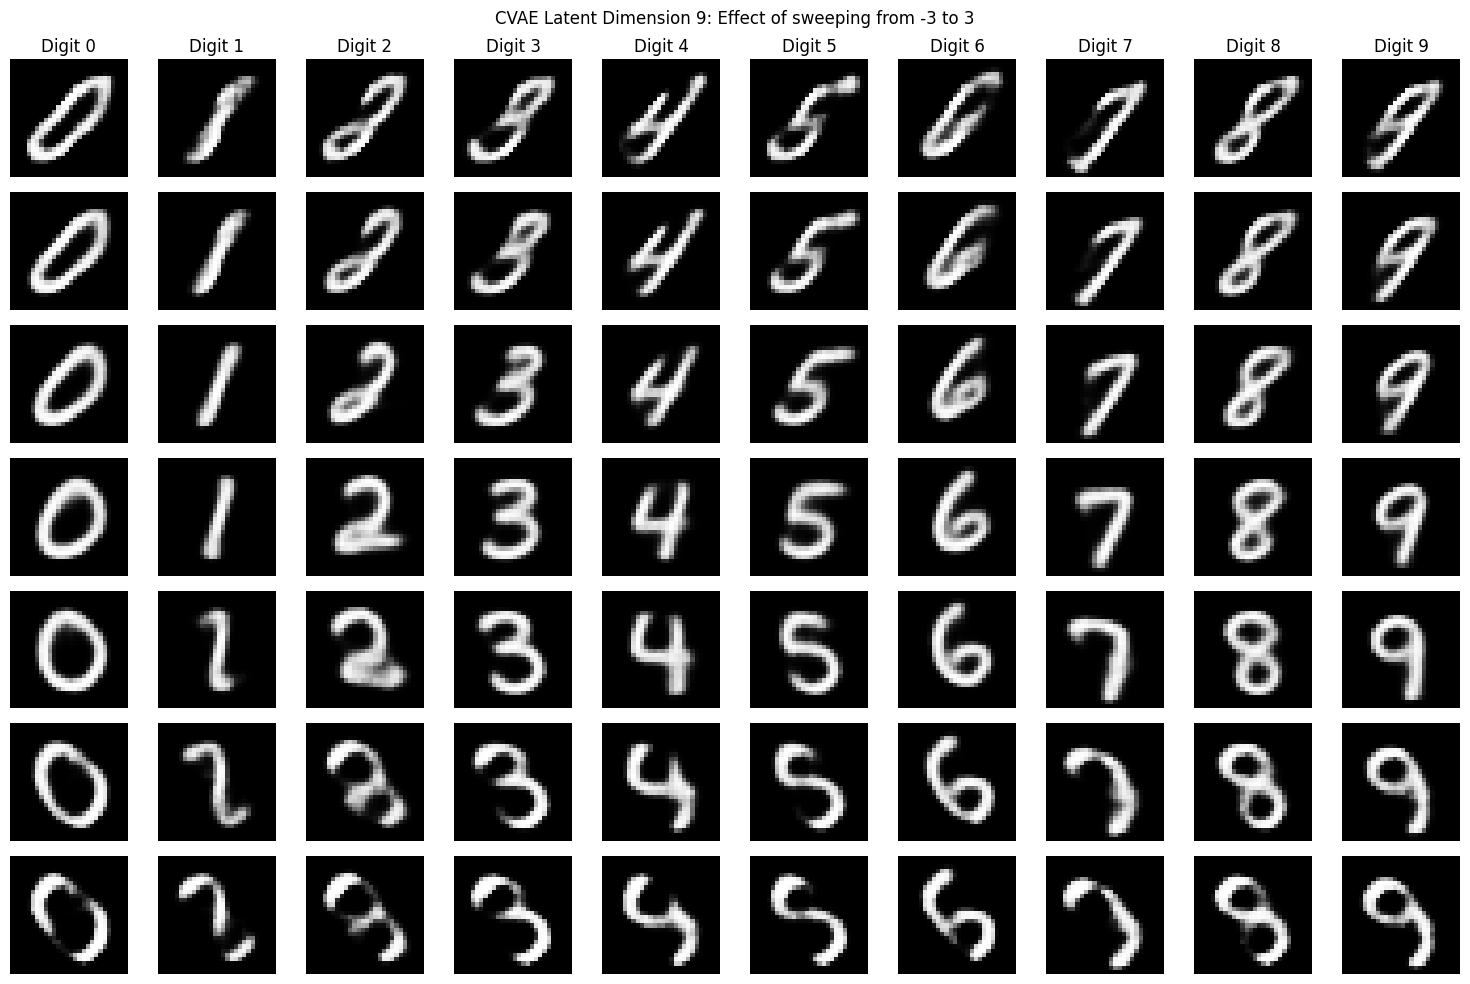

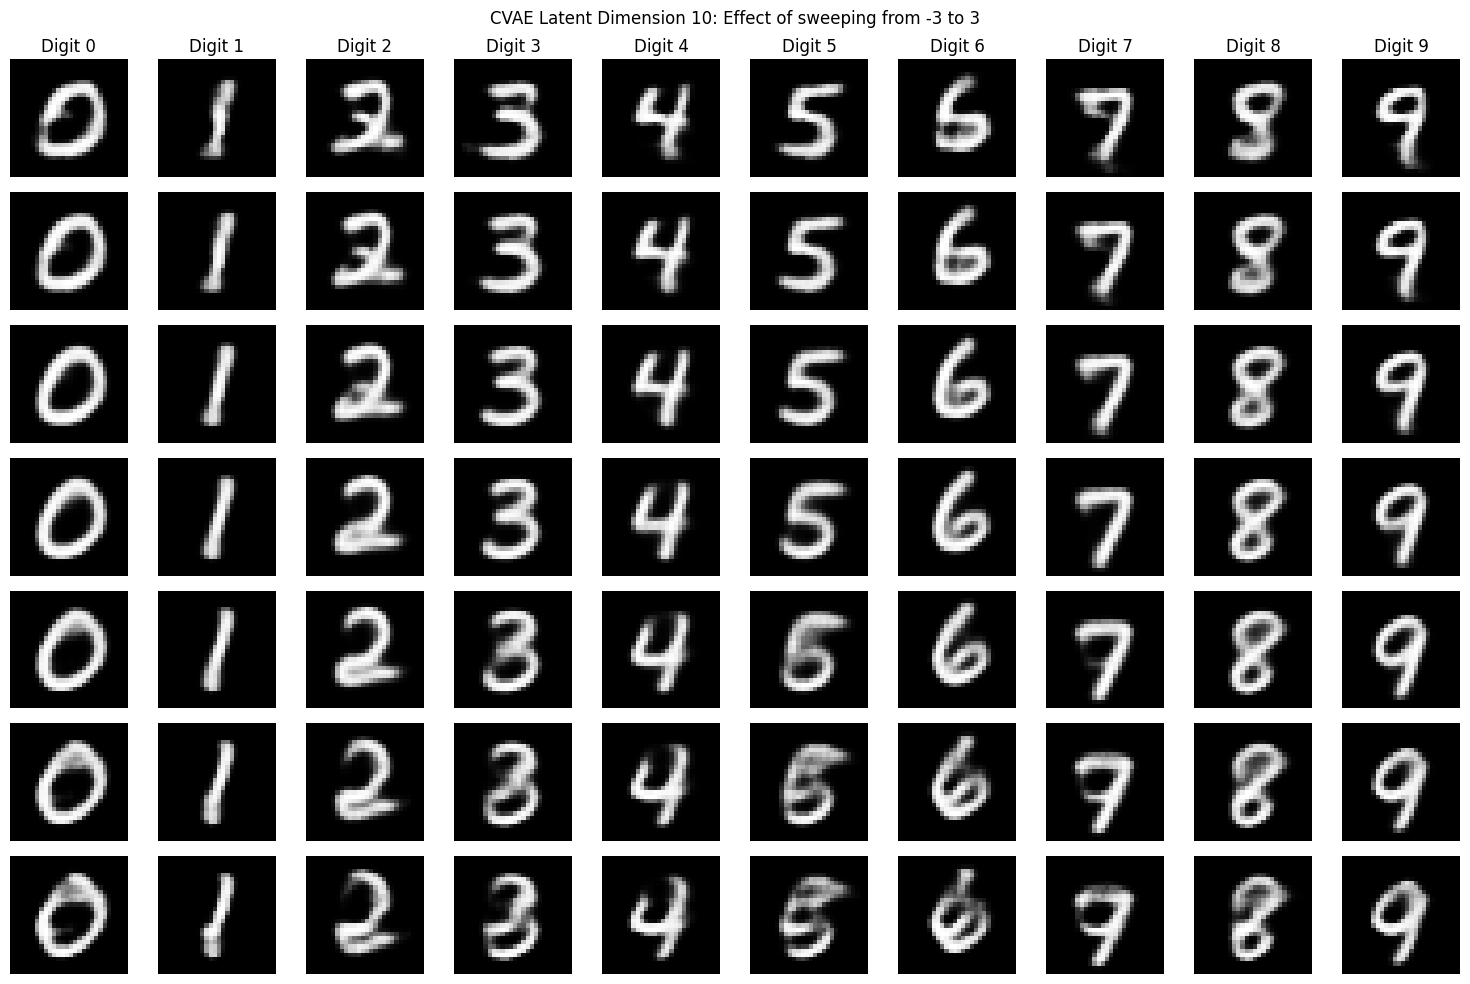

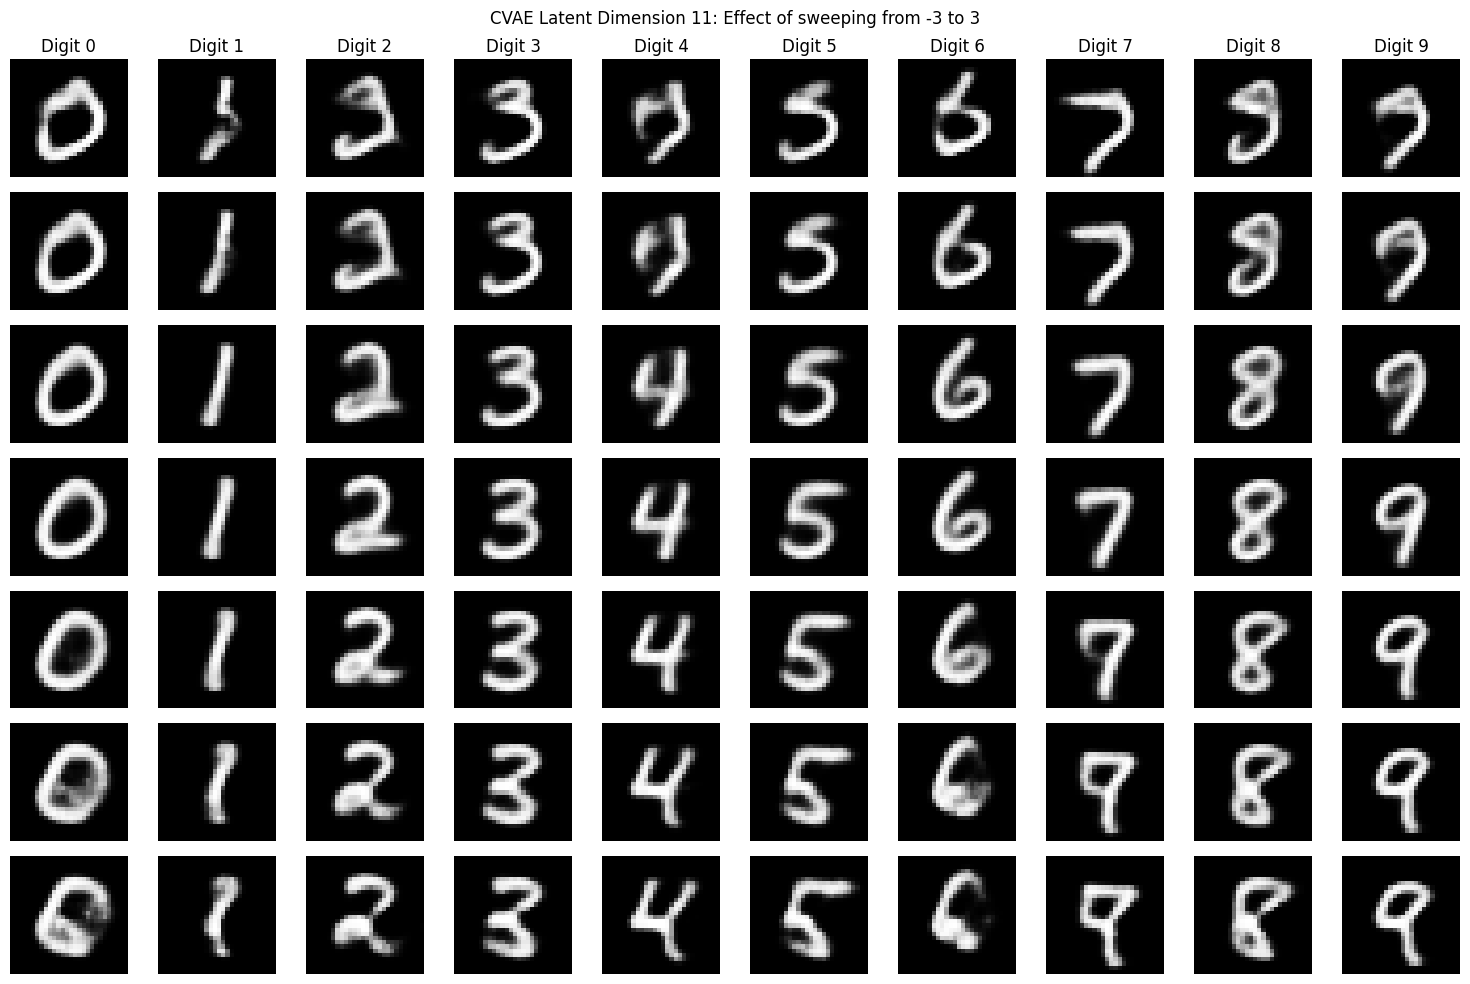

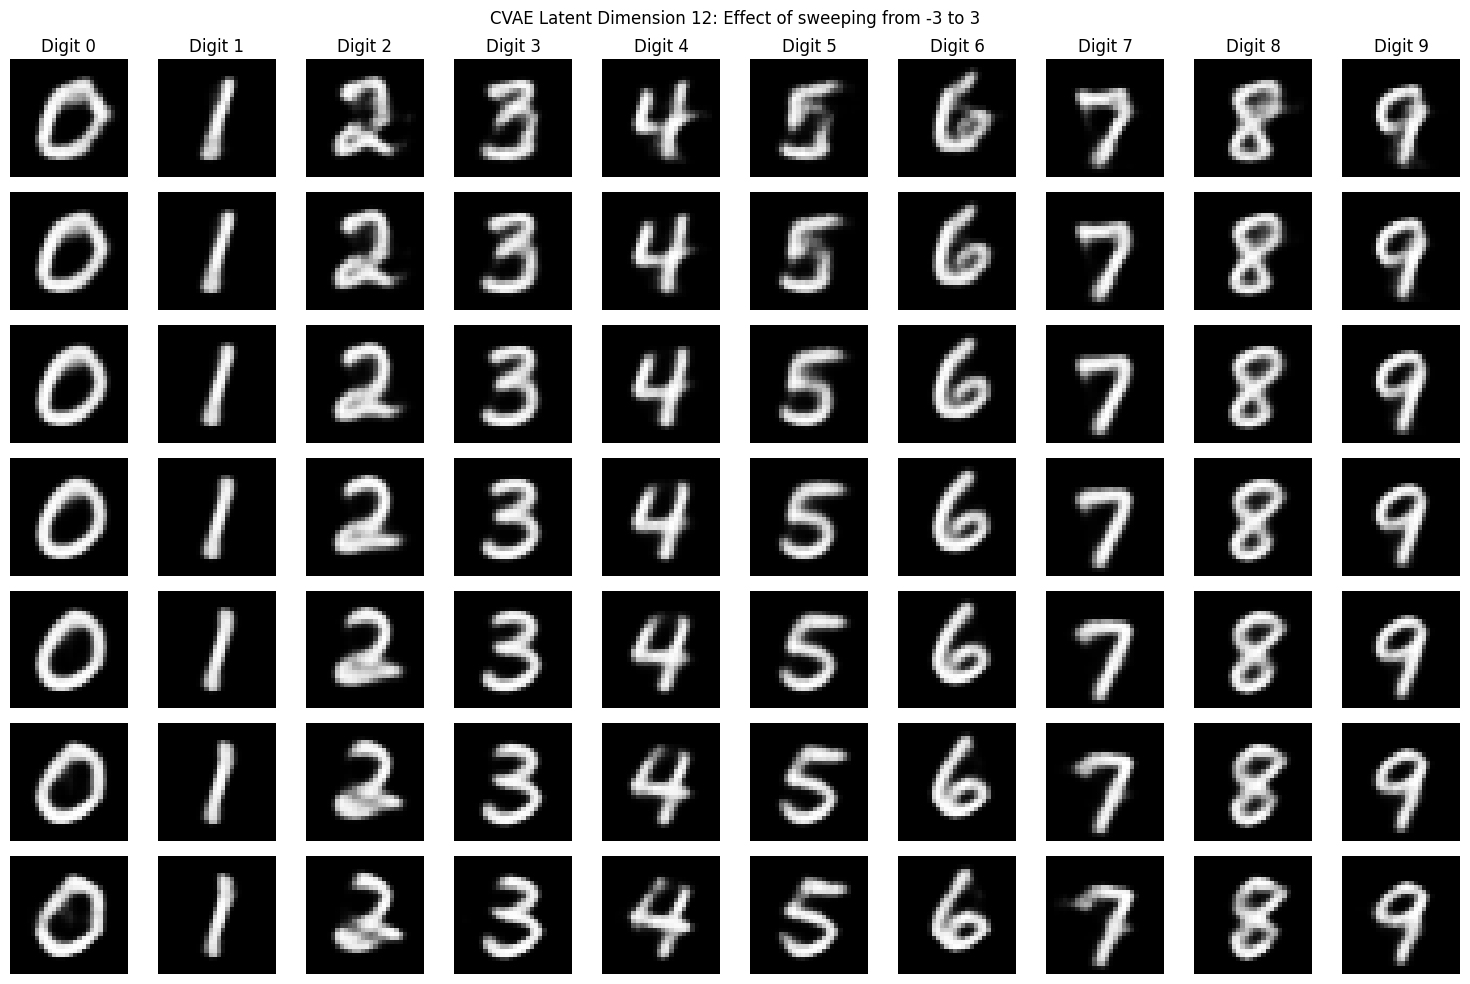

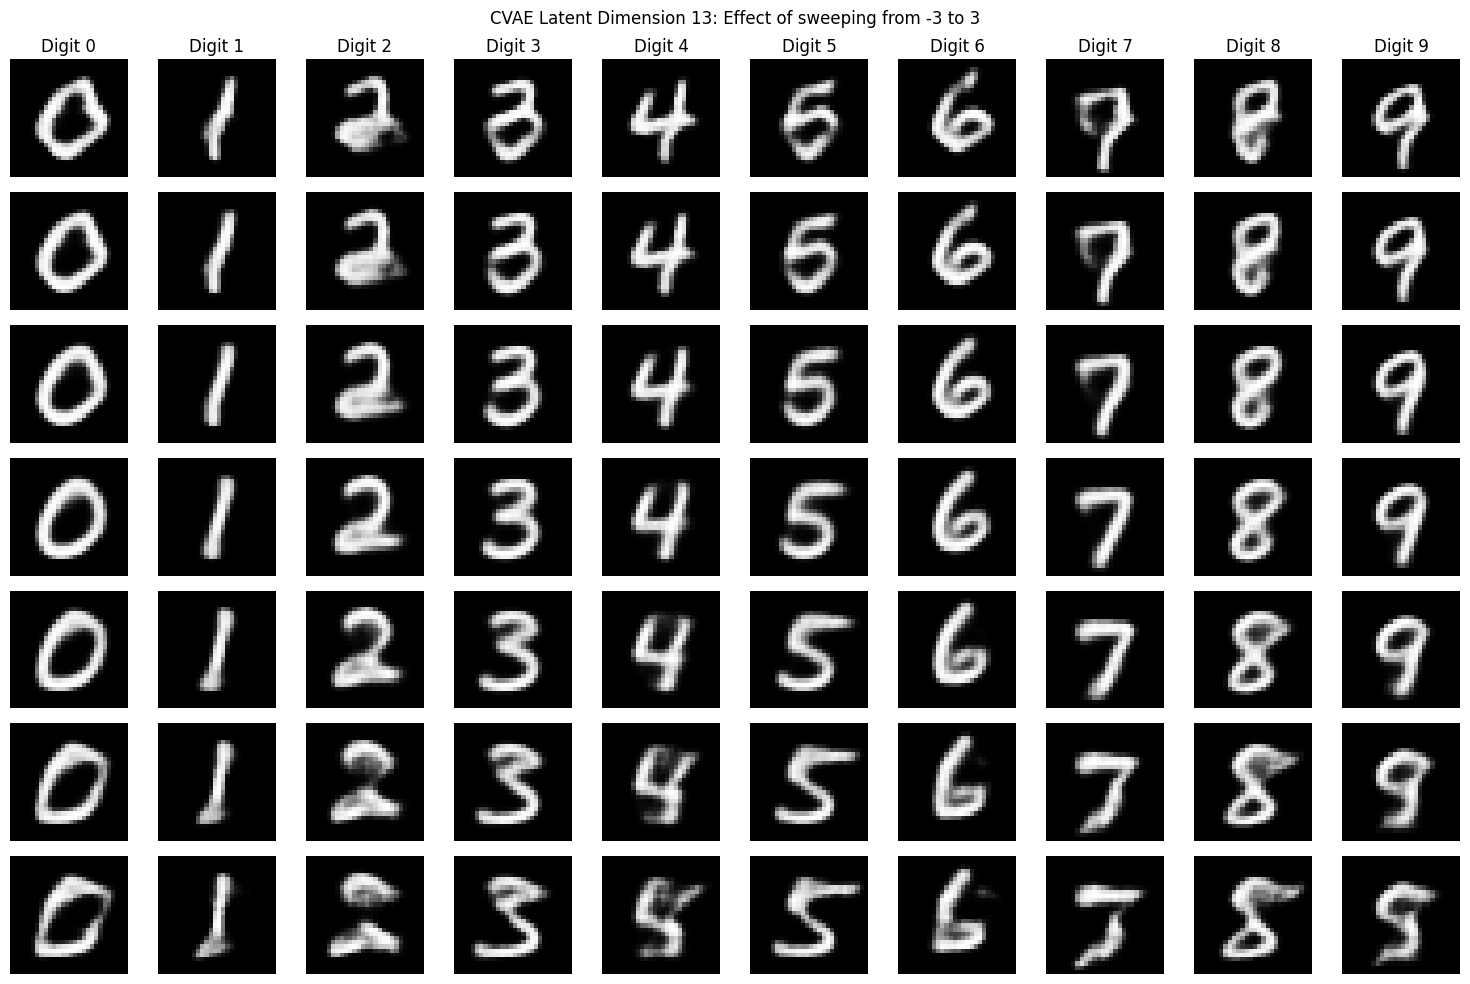

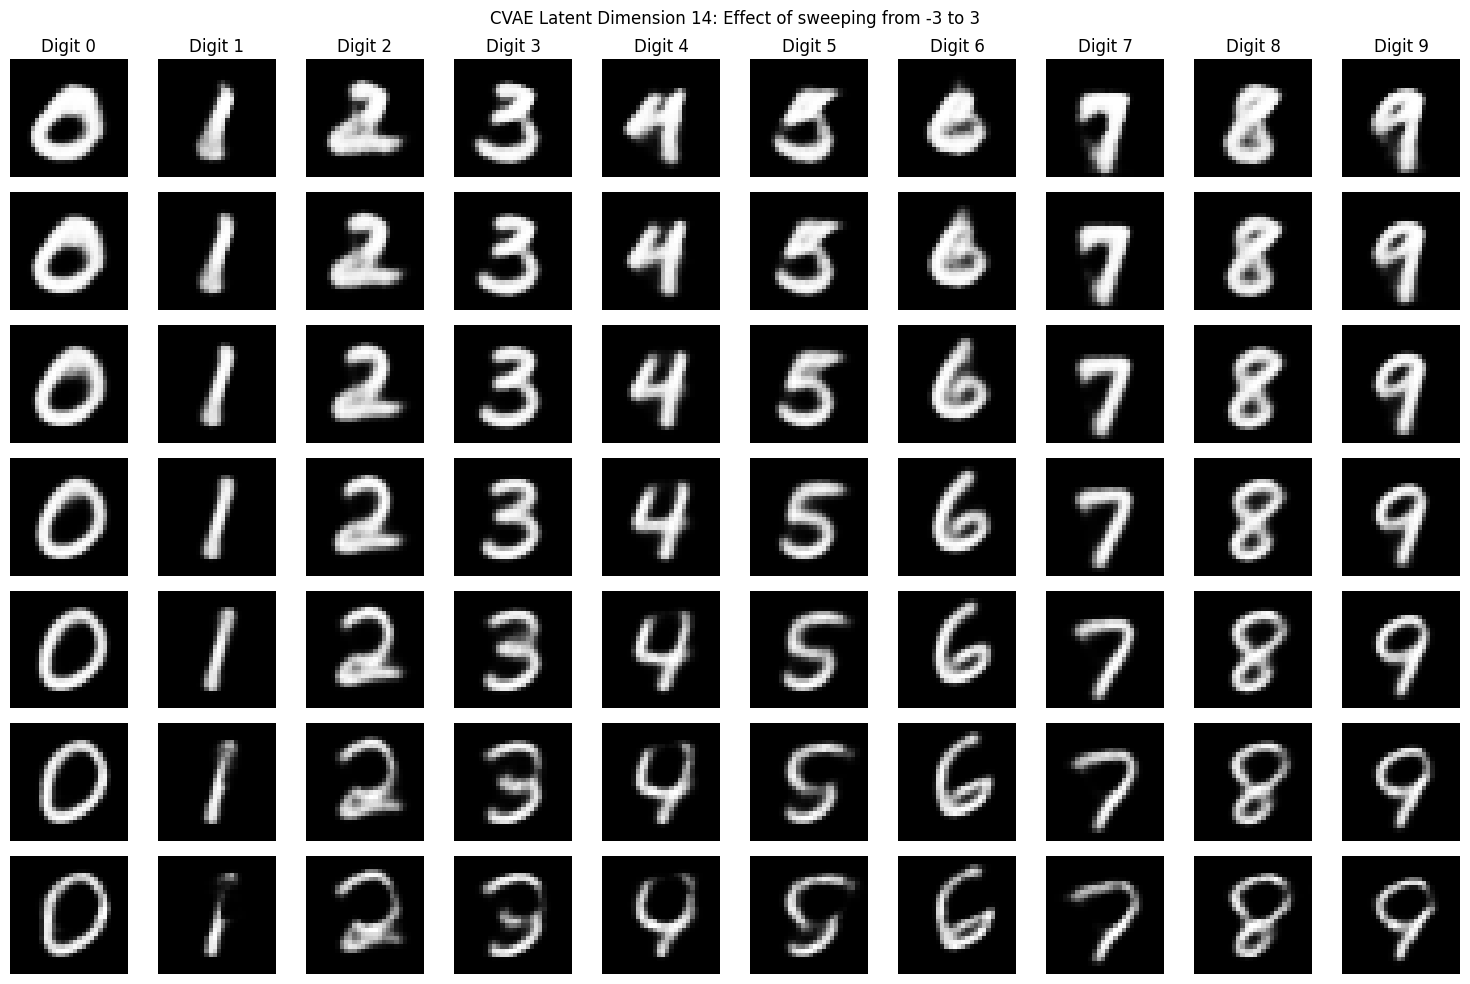

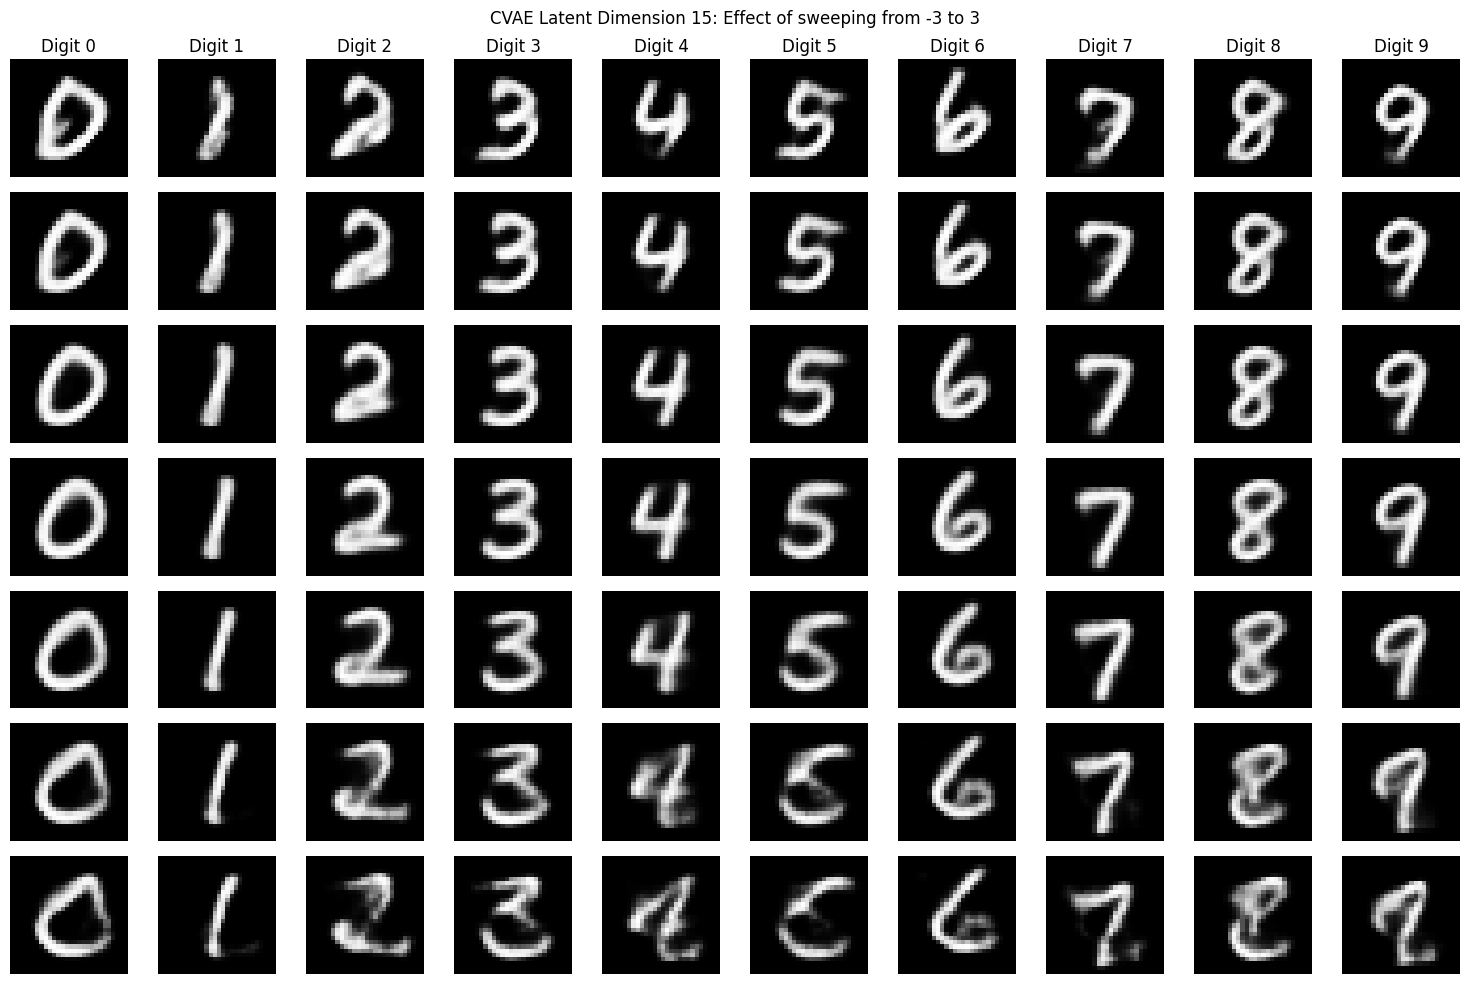

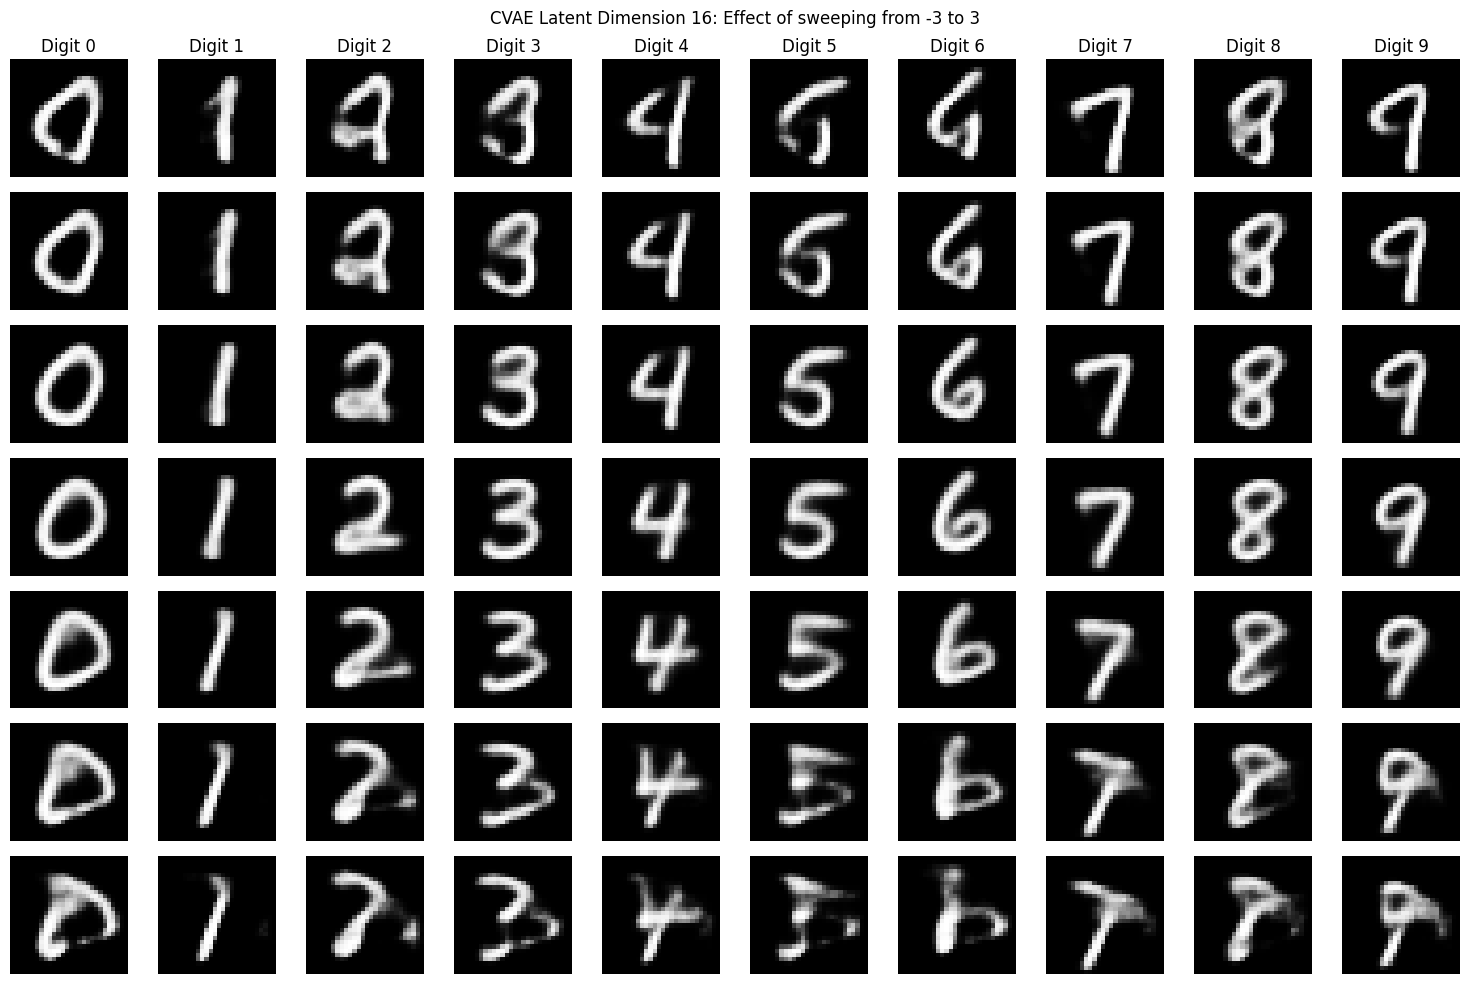

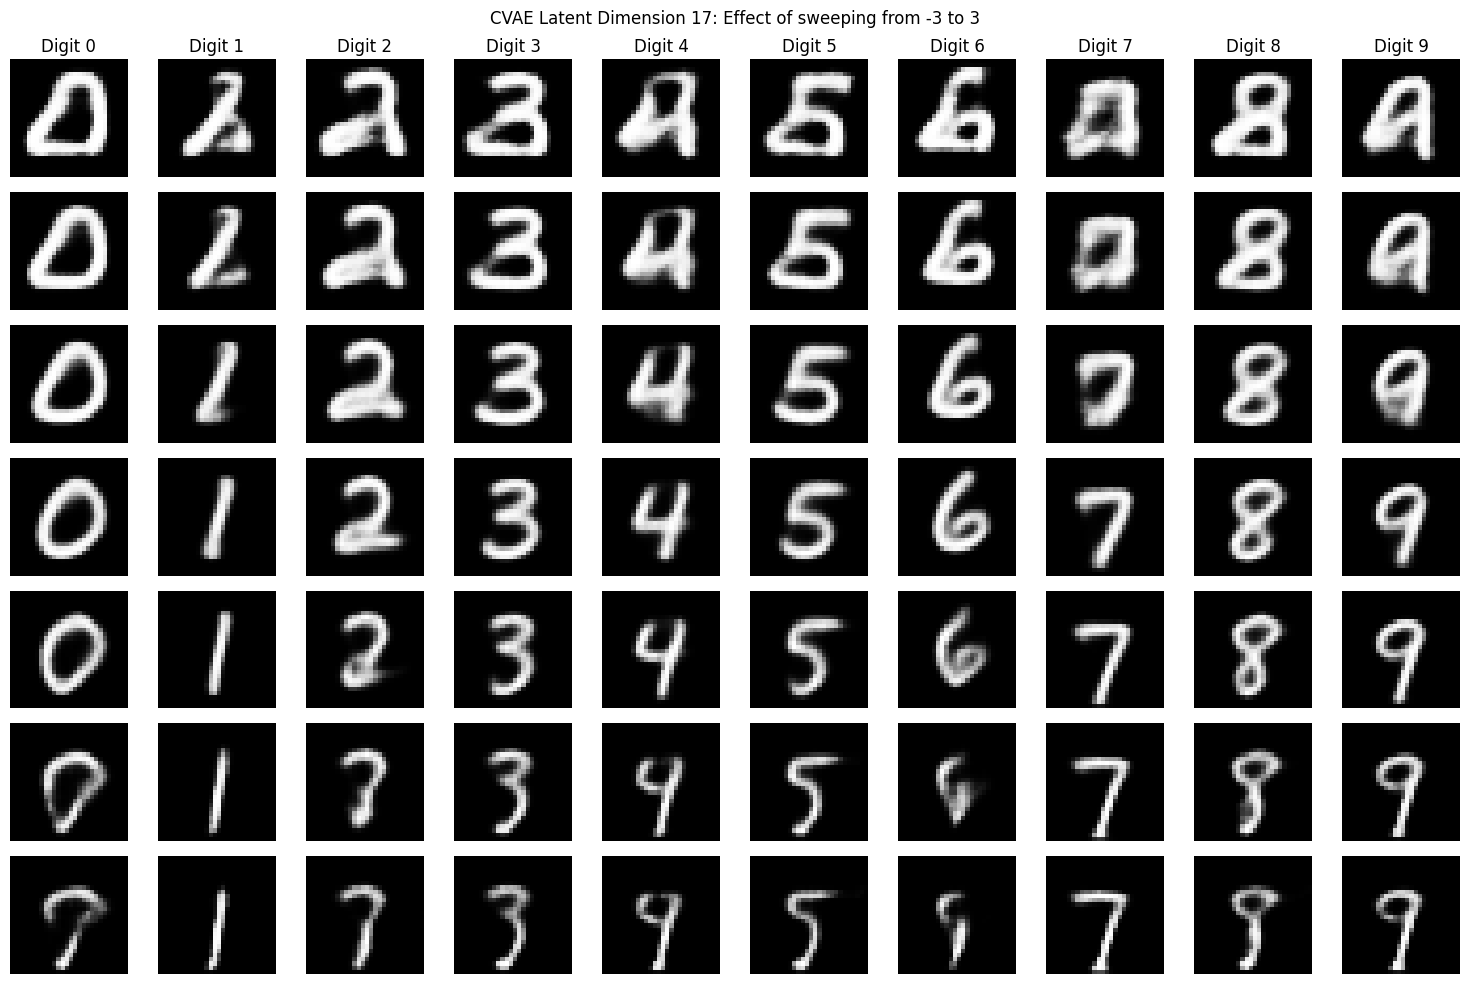

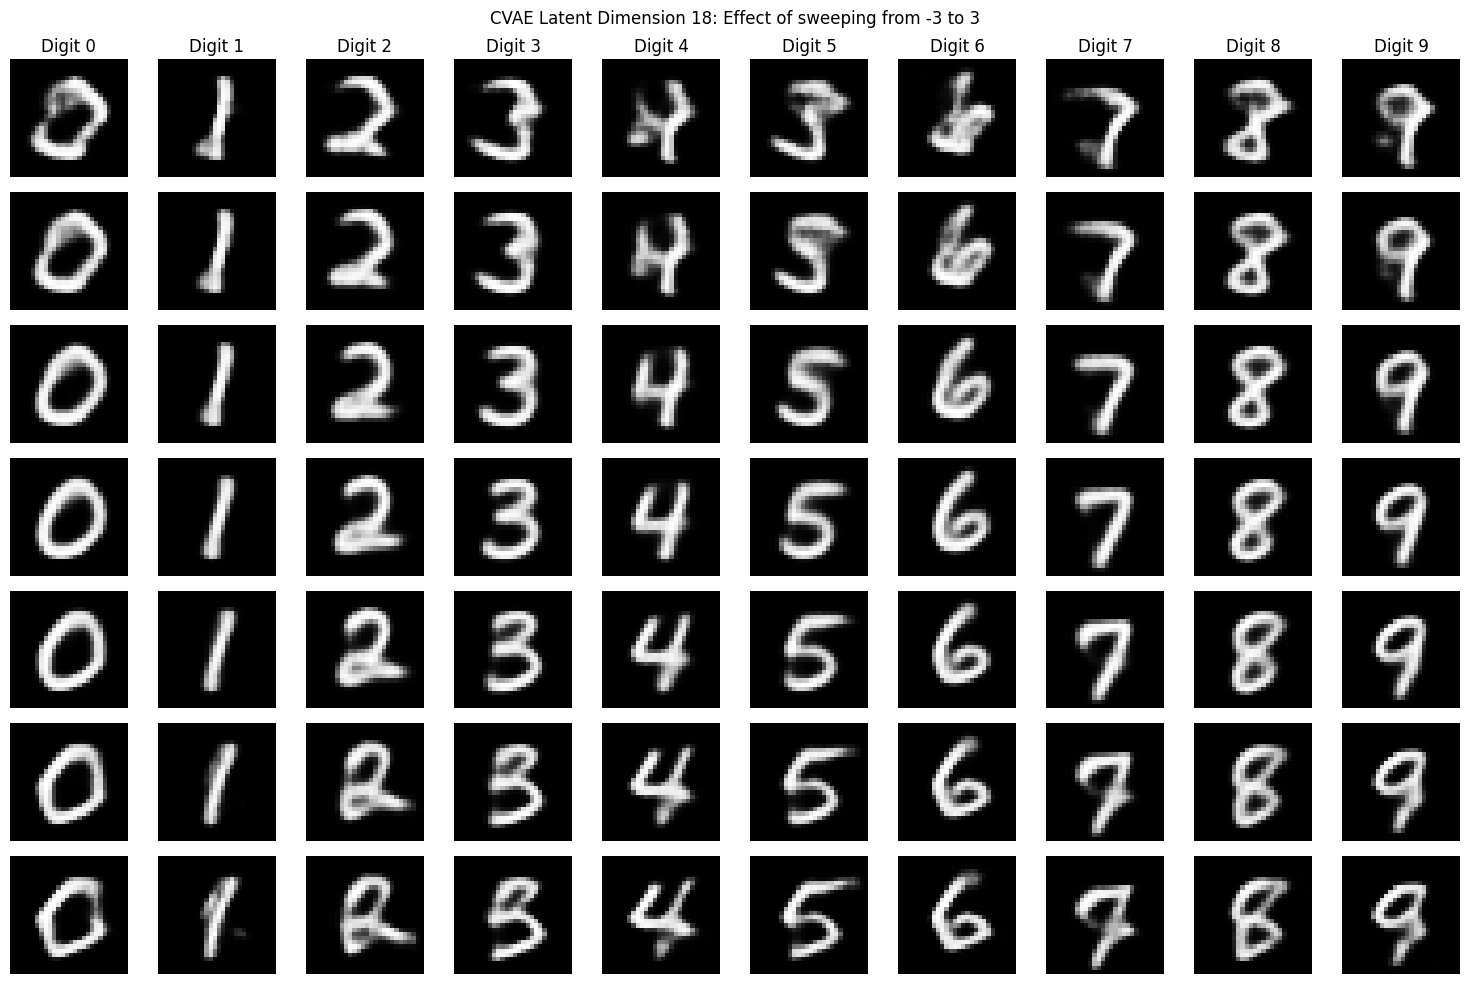

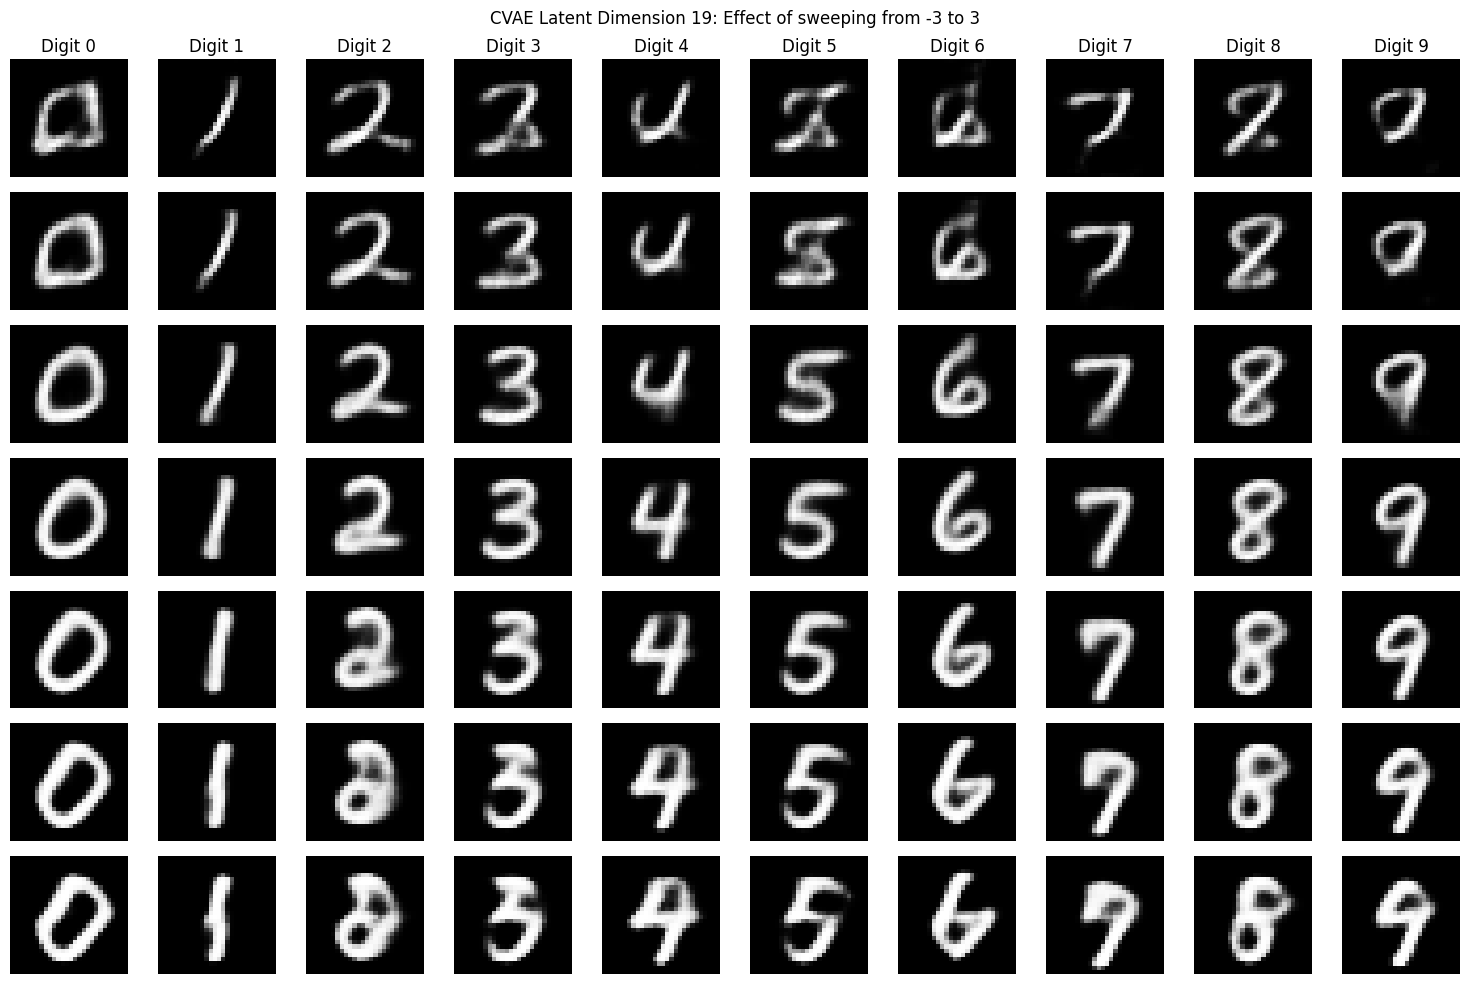

In [26]:
num_digits = 10
sweep_points = 7  # number of points from -3 to 3
sweep_range = torch.linspace(-5, 5, sweep_points).to(device)

model.eval()
with torch.no_grad():
    # Create digit labels (0-9)
    digits = torch.arange(num_digits).to(device)
    # Create one-hot encoded labels for all digits
    y_s = torch.nn.functional.one_hot(digits, num_classes=10).float()  # shape: [10, 10]
    
    # For each latent dimension
    for dim in range(latent_dim):
        # Create figure for this dimension
        fig, axes = plt.subplots(sweep_points, num_digits, figsize=(15, 10))
        plt.suptitle(f'CVAE Latent Dimension {dim}: Effect of sweeping from -3 to 3')
        
        # For each sweep value
        for i, sweep_val in enumerate(sweep_range):
            # Initialize z vector with zeros
            z = torch.zeros(num_digits, latent_dim).to(device)
            # Set the chosen dimension to the sweep value
            z[:, dim] = sweep_val
            
            # Generate samples for all digits at this sweep value
            samples = model.decoder(z, y_s)  # shape: [10, 1, 28, 28]
            
            # Plot the results
            for j in range(num_digits):
                ax = axes[i, j]
                ax.imshow(samples[j][0].cpu(), cmap='gray')
                ax.axis('off')
                
                if i == 0:  # Add column labels (digits) on top
                    ax.set_title(f'Digit {j}')
                if j == 0:  # Add row labels (sweep values) on left
                    ax.set_ylabel(f'z_{dim}={sweep_val:.1f}', rotation=0, labelpad=20)
        
        plt.tight_layout()
        plt.show()